# 1. Feature evaluation
## Load dependencies and data

Note that tourney_level, player_1, player_2 and surface should only be used to evaluate specific situations since these are not a "difference feature". All other features for a match is the difference in performance/situation for the two players.

In [90]:
import os
import json
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz

from definitions import GEN_PATH, ROOT_DIR
from utilities.helper import logger

sns.set_context('notebook')
sns.set_style('white')
sns.set(style="whitegrid")

# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename_final'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

# Split data set into train and test, start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Initial model parameters
rf_max_depth = 10  # arbitrary number used only feature evaluation
rf_estimators = 100  # future default in sklearn
lr_solver = 'lbfgs'  # Only supports Ridge regularization

## Declare notebook wide functions

In [72]:
@logger
def start_pipe(df):
    return df.copy()

@logger
def extract_by_date(df, begin = None, end = None):
    df.dropna(inplace=True)
    
    if begin is None and end is None:
        return df
    elif begin is None:
        return df.loc[df['tourney_date'] < end]
    elif end is None:
        return df.loc[df['tourney_date'] >= begin]
    else:
        return df.loc[(df['tourney_date'] >= begin) & (data['tourney_date'] < end)]

@logger
def one_hot_encode(df):
    df = pd.get_dummies(df, columns=['home_advantage'])

    renames = {
        'home_advantage_-1.0': 'p2_home',
        'home_advantage_0.0': 'none_home',
        'home_advantage_1.0': 'p1_home',
    }

    return df.rename(columns=renames)    

@logger
def extract_main_tourneys(df):
    return df.loc[(df['tourney_level'] == 2) | (df['tourney_level'] == 3)]

@logger
def get_points(df):
    level_map = config['tourney_levels']
    points_map = config['match_points']
    
    def get_match_points(level):
        for key, value in level_map.items():
            if value == level:
                return points_map[key]

    df['match_points'] = df['tourney_level'].apply(get_match_points, convert_dtype=True)
    return df

@logger
def prune_columns(df):
    # These are only interested for evaluating specific situations
    drop_cols = ['outcome', 'tourney_date', 'tourney_level', 'player_1', 'player_2', 'surface']
    df_y = df['outcome']
    df_x = df.drop(drop_cols, axis=1)
    return df_x, df_y

def plot_rf_feat_imp(importances, columns):
    feat_imp = pd.Series(importances, index=columns)
    feat_imp = feat_imp.sort_values(ascending=False)
    sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
    plt.show()

def plot_lr_feat_sign(X, coeffs):
    std_dev = np.std(X, 0)
    influence = std_dev*np.abs(coeffs)
    influence.sort_values(ascending=False, inplace=True)
    sns.barplot(x=influence.to_list(), y=influence.index, color='b')
    plt.show()

def plot_hyperparam(accs, params):
    sns.lineplot(params, accs)
    plt.show()

## Extract training and validation data

In [54]:
X_train_full, y_train_full = (data
    .pipe(extract_by_date, end=test_date_begin)
    .pipe(one_hot_encode)
    .pipe(prune_columns))

# Split into validation and training part
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=42)

display(X_train)

extract_by_date took=0:00:00.040938 shape=(91435, 18)
one_hot_encode took=0:00:00.057600 shape=(91435, 20)
prune_columns took=0:00:00.010800 shape=(91435, 14)(91435,)


,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,age_diff,p2_home,none_home,p1_home
13005,-0.328981,-0.372376,1.443146,1.522080,2.290345,0.138407,-0.035488,-0.092580,0.004406,0.000408,0.471819,0,1,0
38678,-0.605043,-0.652218,-0.000751,-0.000729,0.000642,0.263015,-0.138409,-0.902241,-2.890145,0.000408,-0.277343,0,1,0
62320,0.223142,-0.185814,0.265753,0.442694,2.460596,-0.070811,1.937613,-0.425970,-0.062909,-2.326092,1.973712,0,1,0
63574,-0.108132,0.280591,0.134490,0.396018,-0.235625,-0.140037,0.518388,0.097928,0.509270,0.410967,-0.926617,0,1,0
61359,0.664842,0.700355,-0.000751,-0.000729,0.000642,-1.026136,0.014618,0.574199,0.004406,0.000408,0.764350,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,0.664842,1.026839,-0.000751,-0.000729,0.000642,-1.006137,0.280045,-0.378343,-0.332169,0.274114,-0.223831,0,1,0
55010,-0.218557,-2.611118,-0.000751,-0.000729,0.000642,1.202956,-0.023300,-0.283089,-0.163882,0.000408,-1.782803,0,1,0
76963,-0.439406,-2.331275,-0.000751,-0.000729,0.000642,0.055335,-0.856147,-0.330716,1.418024,0.000408,-0.644789,0,1,0
863,-0.439406,-0.325735,-0.000751,-0.000729,0.000642,0.044567,-0.948234,-0.997495,-0.433142,0.000408,1.279845,0,1,0


## Correlation heatmap of all features

This shows a high correlation between some of the features (which is naturual). Find out which to remove by checking the feature importance in the next steps.

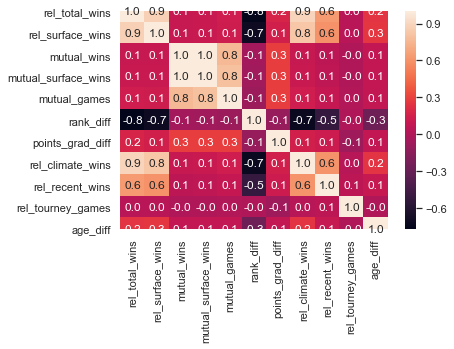

In [6]:
X_train_heat = X_train.drop(['p2_home', 'none_home', 'p1_home'], axis=1)
sns.heatmap(X_train_heat.corr(), annot=True, fmt='.1f')
plt.show()

## Feature importance by RandomForest
Which features help split our tree in the best way possible, i.e. how does each feature affect the accuracy of our model?

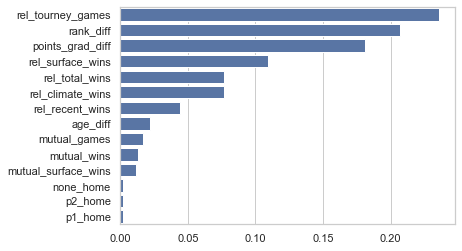

In [5]:
rf_model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rf_model.fit(X_train, y_train)
plot_rf_feat_imp(rf_model.feature_importances_, X_train.columns)

## Recursive feature elimination by RandomForest
Prunes the results from previous sections by selecting the 4 most important features. A ranking of 1 means the algorithm suggests the feature. Results correspond to plot above.

In [85]:
rfe_model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rfe_model = RFE(rfe_model, n_features_to_select=4)  # selects 4 of the features
rfe_model.fit(X_train, y_train)

rankings = rfe_model.ranking_
idx = np.argsort(rankings)
rankings = rankings[idx]
columns = X_train.columns[idx]

rfe_results = pd.DataFrame(rankings, index=columns, columns=['Ranking'])
rfe_results.index.name = 'Feature'
display(rfe_results)

print(f"Number of features selected: {rfe_model.n_features_}")

,Ranking
Feature,
rel_surface_wins,1
rank_diff,1
points_grad_diff,1
rel_tourney_games,1
rel_total_wins,2
rel_climate_wins,3
rel_recent_wins,4
age_diff,5
mutual_games,6


Number of features selected: 4


## Feature importance by logistic regression

Below mostly confirms 7 most important features from RF model but with different significances with the exception that mutual_games is swapt for rel_recent_matches. Note that all columns are already standardized except for the p1_home, p2_home and none_home.

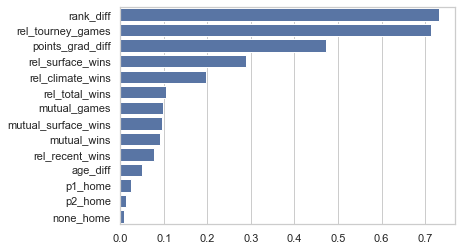

In [6]:
lr_model = LogisticRegression(solver=lr_solver)
lr_model.fit(X_train, y_train)    
plot_lr_feat_sign(X_train, lr_model.coef_[0])

## Prune correlated and poorly significant features for both models

Keep the most significant features but remove any the highly correlated features that are less significant: rel_total_wins, rel_climate_wins. 

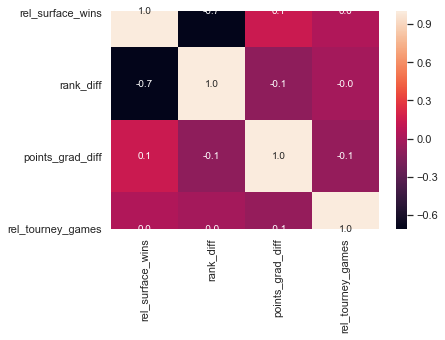

Feature importance for Final RF Model


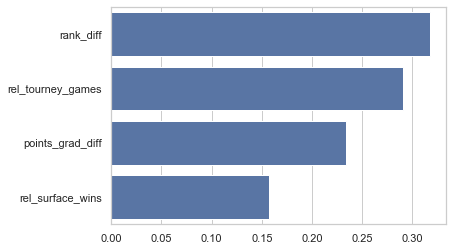

Feature importance for Final LogReg Model


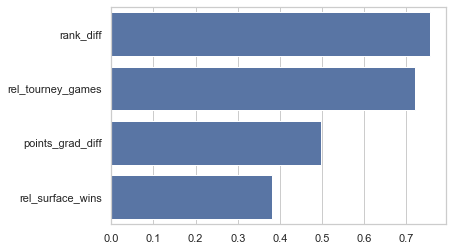

In [7]:
final_columns = ['rel_surface_wins', 'rank_diff', 'points_grad_diff', 'rel_tourney_games']
X_train_final = X_train.filter(final_columns)

# Check new correlation plot
sns.heatmap(X_train_final.corr(), annot=True, fmt='.1f')
plt.show()

rf_model_final = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rf_model_final.fit(X_train_final, y_train)

lr_model_final = LogisticRegression(solver=lr_solver)
lr_model_final.fit(X_train_final, y_train)

# Check new feature importances and significance
print('Feature importance for Final RF Model')
plot_rf_feat_imp(rf_model_final.feature_importances_, X_train_final.columns)

print('Feature importance for Final LogReg Model')
plot_lr_feat_sign(X_train_final, lr_model_final.coef_[0])

## Check classification reports given different features

As one can see below, no performance on static validation set is lossed for any of the two algorithms. Thus since confirmed by two models, for the model selection part, even though different models may like different features, the final_column features are the ones that will be used to test different models. Also, no difference in metrics can be seen which is naturual since our data set is exactly balanced.

In [8]:
X_val_final = X_val.filter(final_columns)

print('Full RandomForest model:')
print(classification_report(y_val, rf_model.predict(X_val)))

print('Final RandomForest model:')
print(classification_report(y_val, rf_model_final.predict(X_val_final)))

print('Full LogReg model:')
print(classification_report(y_val, lr_model.predict(X_val)))

print('Final LogReg model:')
print(classification_report(y_val, lr_model_final.predict(X_val_final)))

Full RandomForest model:
              precision    recall  f1-score   support

        -1.0       0.73      0.73      0.73     15101
         1.0       0.73      0.73      0.73     15073

    accuracy                           0.73     30174
   macro avg       0.73      0.73      0.73     30174
weighted avg       0.73      0.73      0.73     30174

Final RandomForest model:
              precision    recall  f1-score   support

        -1.0       0.73      0.74      0.73     15101
         1.0       0.73      0.72      0.73     15073

    accuracy                           0.73     30174
   macro avg       0.73      0.73      0.73     30174
weighted avg       0.73      0.73      0.73     30174

Full LogReg model:
              precision    recall  f1-score   support

        -1.0       0.72      0.72      0.72     15101
         1.0       0.72      0.73      0.72     15073

    accuracy                           0.72     30174
   macro avg       0.72      0.72      0.72     30174
weig

# 2. Model Selection

This part is dedicated to hyper parameter tuning and model selection. Cross validation will be used to commpare the models but not to tune the hyperparameters.

Also, most models will be evaluated using the four final features identified above. However, a Neural Network will also be trained using all features to see. This will not be the case for SVM since it is too slow to train...

In [9]:
no_folds = 10  # number of folds
X_train_final_full = X_train_full.filter(final_columns)

## Logistic Regression

### Calibration
Calibration of hyperparameter C which is the inverse of regularization strength.

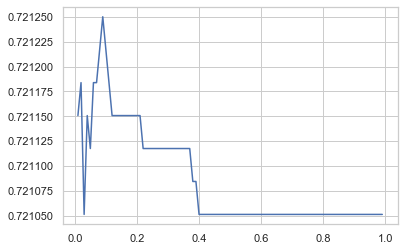

Best C: 0.09 with accuracy: 0.7212500828527871


In [23]:
accuracies = []
c_vals = list(np.arange(0.01, 1, 0.01))
best_acc = 0
best_c = 0

for c in c_vals:
    lr_model_cal = LogisticRegression(solver=lr_solver, C=c)
    lr_model_cal.fit(X_train_final, y_train)
    predictions = lr_model_cal.predict(X_val_final)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_c = c
    
    accuracies.append(acc)

plot_hyperparam(accuracies, c_vals)

print(f"Best C: {best_c} with accuracy: {best_acc}")

### Cross validation score

In [27]:
optimal_c = 0.09
lr_model_final = LogisticRegression(solver=lr_solver, C=optimal_c)
lr_scores = cross_val_score(lr_model_final, X_train_final_full, y_train_full, cv=no_folds)
print("Logistic Regression accuracy: %0.3f (+/- %0.3f)" % (lr_scores.mean(), lr_scores.std() * 2))

Logistic Regression accuracy: 0.721 (+/- 0.015)


## Random Forest

### Calibration

Calibration of max tree depth

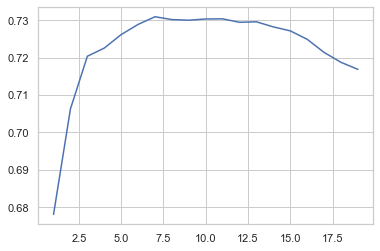

Best max_depth: 7 with accuracy: 0.7309604295088487


In [29]:
accuracies = []
depths = list(np.arange(1, 20, 1))
best_acc = 0
best_depth = 0

for max_depth in depths:
    rf_model_cal = RandomForestClassifier(max_depth=max_depth, n_estimators=rf_estimators)
    rf_model_cal.fit(X_train_final, y_train)
    predictions = rf_model_cal.predict(X_val_final)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_depth = max_depth
    
    accuracies.append(acc)

plot_hyperparam(accuracies, depths)

print(f"Best max_depth: {best_depth} with accuracy: {best_acc}")

### Cross validation score

In [30]:
optimal_max_depth = 7
rf_model_final = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=rf_estimators)
rf_scores = cross_val_score(rf_model_final, X_train_final_full, y_train_full, cv=no_folds)
print("Random Forest accuracy: %0.3f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))

Logistic Regression accuracy: 0.730 (+/- 0.016)


## k-Neighbours

### Calibration of number of neighbors with uniform weighting

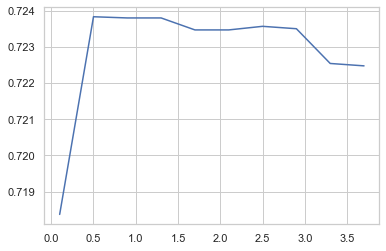

Best factor uniform: 0.5 (base k: 247.50959577357804) with accuracy: 0.7238350898124213


In [49]:
def calibrate_neighbors(base_k, weights):
    accuracies = []
    k_factors = list(np.arange(0.1, 4, 0.4))
    best_acc = 0
    best_factor = 0

    for factor in k_factors:
        k = int(round(base_k * factor))
        knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights)
        knn_model.fit(X_train_final, y_train)
        predictions = knn_model.predict(X_val_final)
        acc = accuracy_score(y_val, predictions)

        if acc > best_acc:
            best_acc = acc
            best_factor = factor

        accuracies.append(acc)
        
    return accuracies, k_factors, best_factor, best_acc

base_k = len(X_train_final) ** 0.5
accuracies, k_factors, best_factor, best_acc = calibrate_neighbors(base_k, 'uniform')
plot_hyperparam(accuracies, k_factors)

print(f"Best factor uniform: {best_factor} (base k: {base_k}) with accuracy: {best_acc}")

### Calibration of number of neighbors with distance weighting

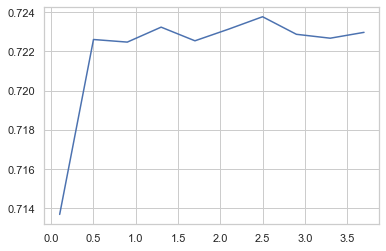

Best factor distance: 2.5000000000000004 (base k: 247.50959577357804) with accuracy: 0.7237688075826871


In [50]:
base_k = len(X_train_final) ** 0.5
accuracies, k_factors, best_factor, best_acc = calibrate_neighbors(base_k, 'distance')
plot_hyperparam(accuracies, k_factors)

print(f"Best factor distance: {best_factor} (base k: {base_k}) with accuracy: {best_acc}")

### Cross validation score

In [46]:
optimal_factor = 0.5
optimal_k = int(round(len(X_train_final) ** 0.5 * optimal_factor))
optimal_weight_func = 'uniform'

knn_model_final = KNeighborsClassifier(n_neighbors=optimal_k, weights=optimal_weight_func)
knn_scores = cross_val_score(knn_model_final, X_train_final_full, y_train_full, cv=no_folds)
print("kNN accuracy: %0.3f (+/- %0.3f)" % (knn_scores.mean(), knn_scores.std() * 2))

kNN accuracy: 0.727 (+/- 0.020)


## SVM

Using a sub sample to evaluate the SVM beause it scales super badly. Also, assuming parameters can be calibrated seperately, even if this is probably not the case all the time.

### Calibration of kernel

Length of train data: 61261, val data: 30174
Sample size train data: 20000, val data: 2000


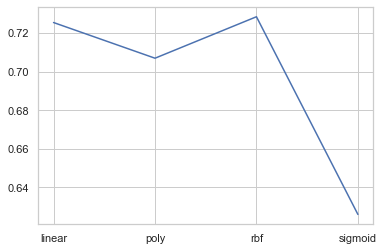

Best kernel: rbf with accuracy: 0.7285


In [23]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = []
best_acc = 0
best_kernel = ''

sample_size_train = 20000
sample_size_val = 2000

print(f"Length of train data: {len(X_train_final)}, val data: {len(X_val_final)}")
print(f"Sample size train data: {sample_size_train}, val data: {sample_size_val}")

X_train_final_svm = X_train_final.sample(sample_size_train, random_state=42)
X_val_final_svm = X_val_final.sample(sample_size_val, random_state=42)
y_train_final_svm = y_train[X_train_final_svm.index]
y_val_final_svm = y_val[X_val_final_svm.index]

for kernel in kernels:
    svm_model_cal = SVC(C=1, kernel=kernel, gamma='scale')
    svm_model_cal.fit(X_train_final_svm, y_train_final_svm)
    predictions = svm_model_cal.predict(X_val_final_svm)
    acc = accuracy_score(y_val_final_svm, predictions)

    if acc > best_acc:
        best_acc = acc
        best_kernel = kernel

    accuracies.append(acc)

plot_hyperparam(accuracies, kernels)
print(f"Best kernel: {best_kernel} with accuracy: {best_acc}")

### Calibration of gamma

Using kernel (rbf) best kernel from above experiment

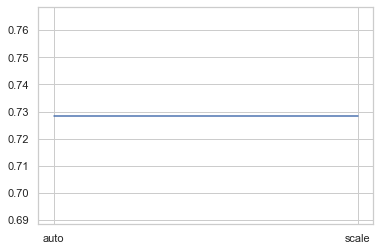

Best gamma: scale with accuracy: 0.7285


In [27]:
optimal_kernel = 'rbf'
gammas = ['scale', 'auto']
accuracies = []
best_acc = 0
best_gamma = ''

for gamma in gammas:
    svm_model_cal = SVC(C=1, kernel=optimal_kernel, gamma=gamma)
    svm_model_cal.fit(X_train_final_svm, y_train_final_svm)
    predictions = svm_model_cal.predict(X_val_final_svm)
    acc = accuracy_score(y_val_final_svm, predictions)

    if acc > best_acc:
        best_acc = acc
        best_gamma = gamma

    accuracies.append(acc)

plot_hyperparam(accuracies, gammas)
print(f"Best gamma: {best_gamma} with accuracy: {best_acc}")

### Calibration of regularization parameter C

This takes a couple of minutes.

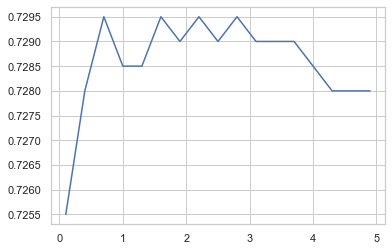

Best C: 0.7000000000000001 with accuracy: 0.7295


In [32]:
optimal_kernel = 'rbf'
optimal_gamma = 'scale'
accuracies = []
c_vals = list(np.arange(0.1, 5, 0.3))
best_acc = 0
best_c = 0

for c in c_vals:
    svm_model_cal = SVC(C=c, kernel=optimal_kernel, gamma=optimal_gamma)
    svm_model_cal.fit(X_train_final_svm, y_train_final_svm)
    predictions = svm_model_cal.predict(X_val_final_svm)
    acc = accuracy_score(y_val_final_svm, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_c = c
    
    accuracies.append(acc)

plot_hyperparam(accuracies, c_vals)

print(f"Best C: {best_c} with accuracy: {best_acc}")

### Cross validation score

FYI: this takes forever (about 30 min) since we need to use CV on the complete training set to compare with the other models...

In [34]:
optimal_kernel = 'rbf'
optimal_gamma = 'scale'
optimal_c = .7

svm_model_final = SVC(C=optimal_c, kernel=optimal_kernel, gamma=optimal_gamma)
svm_scores = cross_val_score(svm_model_final, X_train_final_full, y_train_full, cv=no_folds)
print("SVM accuracy: %0.3f (+/- %0.3f)" % (svm_scores.mean(), svm_scores.std() * 2))

kNN accuracy: 0.729 (+/- 0.016)


## Neural Network

A maximum of 2 hidden layers with a different amount of nodes will be evaluated given (more than 2 seems unnecessary given the complexity of the problem). Also, assuming activation function, alpha and number of layers/nodes can be calibrated seperately. A Neural Network trained on all featres will be tested in the end.

### Calibration of activation function

Using 1 hidden layer and rule of thumb nodes = 2/3 \* input size + output size

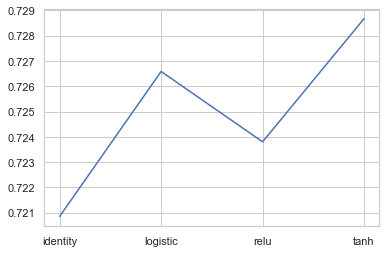

Best activation: tanh with accuracy: 0.7286736925830185


In [38]:
no_nodes = int(round(len(X_train_final.columns)*2/3 + 1))  # rule of thumb
hidden_layer_sizes = (no_nodes,)
alpha = 0.0001  # default

activations = ['identity', 'logistic', 'tanh', 'relu']
accuracies = []
best_acc = 0
best_act = 0

for act in activations:
    nn_model_cal = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=act, alpha=alpha)
    nn_model_cal.fit(X_train_final, y_train)
    predictions = nn_model_cal.predict(X_val_final)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_act = act
    
    accuracies.append(acc)

plot_hyperparam(accuracies, activations)

print(f"Best activation: {best_act} with accuracy: {best_acc}")

### Calibration of network structure

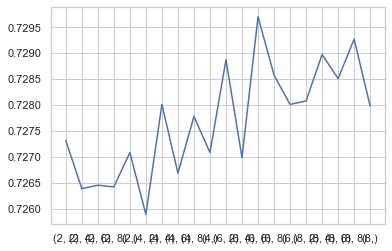

Best network structure: (6, 6) with accuracy: 0.7297010671438987


In [11]:
optimal_act = 'tanh'
no_features = len(X_train_final.columns)
alpha = 0.0001  # default

nodes_range = np.arange(2, no_features * 2 + 1, 2)
network_structures = []
accuracies = []

for layers in range(1,3):
    for first_nodes in nodes_range:    
        if layers == 1:
            network_structures.append((first_nodes,))
        elif layers == 2:
            for sec_nodes in nodes_range:
                network_structures.append((first_nodes, sec_nodes))
                
str_network_structures = []

for struct in network_structures:
    str_network_structures.append(str(struct))

best_acc = 0
best_struct = ()

for struct in network_structures:
    nn_model_cal = MLPClassifier(hidden_layer_sizes=struct, activation=optimal_act, alpha=alpha)
    nn_model_cal.fit(X_train_final, y_train)
    predictions = nn_model_cal.predict(X_val_final)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_struct = struct
    
    accuracies.append(acc)

plot_hyperparam(accuracies,str_network_structures)
print(f"Best network structure: {str(best_struct)} with accuracy: {best_acc}")

### Calibration of regularization parameter alpha

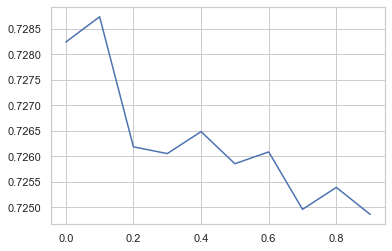

Best alpha: 0.10010000000000001 with accuracy: 0.7287399748127527


In [13]:
optimal_act = 'tanh'
optimal_struct = (6, 6)
alphas = list(np.arange(0.0001, 1, 0.1))

accuracies = []
best_acc = 0
best_alpha = 0

for alpha in alphas:
    nn_model_cal = MLPClassifier(hidden_layer_sizes=optimal_struct, activation=optimal_act, alpha=alpha)
    nn_model_cal.fit(X_train_final, y_train)
    predictions = nn_model_cal.predict(X_val_final)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
    
    accuracies.append(acc)

plot_hyperparam(accuracies, alphas)

print(f"Best alpha: {best_alpha} with accuracy: {best_acc}")

### Cross validation score

In [14]:
optimal_act = 'tanh'
optimal_struct = (6,6)
optimal_alpha = 0.1

nn_model_final = MLPClassifier(hidden_layer_sizes=optimal_struct, activation=optimal_act, alpha=optimal_alpha)
nn_scores = cross_val_score(nn_model_final, X_train_final_full, y_train_full, cv=no_folds)
print("Neural Network accuracy: %0.3f (+/- %0.3f)" % (nn_scores.mean(), nn_scores.std() * 2))

kNN accuracy: 0.728 (+/- 0.014)


### Experiment: Running NN model on all features

Using default alpha and activation function given above and rule of thumb of 2 hidden layers just to see if we are missing out on any features. It seems a neural network using with the possibility to use all features performs slightly better. However, given the increased model complexity, training time and black-box approach, this does not feel like the preferred method.

In [23]:
no_nodes = int(round(len(X_train.columns)*2/3 + 1))
exp_act = 'tanh'
exp_struct = (no_nodes, no_nodes)
exp_alpha = 0.0001

nn_model_exp = MLPClassifier(hidden_layer_sizes=exp_struct, activation=exp_act, alpha=exp_alpha)
nn_exp_scores = cross_val_score(nn_model_exp, X_train_full, y_train_full, cv=no_folds)
print("Neural Network (all features) accuracy: %0.3f (+/- %0.3f)" % (nn_exp_scores.mean(), nn_exp_scores.std() * 2))

Neural Network (all features) accuracy: 0.733 (+/- 0.016)


# 3. Testing and comparison to base model

## Extract test data

In [58]:
X_test, y_test = (data
    .pipe(start_pipe)
    .pipe(extract_by_date, begin=test_date_begin)
    .pipe(one_hot_encode)
    .pipe(prune_columns))

display(X_test)

X_test_final = X_test.filter(final_columns)

start_pipe took=0:00:00.031000 shape=(118414, 18)
extract_by_date took=0:00:00.046473 shape=(26979, 18)
one_hot_encode took=0:00:00.018245 shape=(26979, 20)
prune_columns took=0:00:00.002349 shape=(26979, 14)(26979,)


,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,age_diff,p2_home,home_advantage_-0.0,p1_home
91608,-0.384194,-0.232454,-0.155880,-0.455822,0.000642,0.087641,-0.119450,-0.521224,0.139037,0.000408,0.203585,0,1,0
91609,-0.328981,-0.372376,-0.000751,-0.000729,0.000642,0.109178,-0.143826,-0.330716,0.273667,0.000408,-1.695631,0,0,1
91610,0.278355,0.047389,-0.000751,-0.000729,0.000642,0.173789,-0.276540,-0.044953,0.542927,0.000408,-1.020723,0,1,0
91611,-0.052919,0.094029,-0.213557,-0.625023,-1.694920,0.007646,-0.021946,-0.187835,0.139037,0.000408,0.529807,0,1,0
91612,-0.328981,0.000748,0.162334,0.477701,0.000642,0.010723,-0.080178,-0.949868,0.004406,0.000408,1.519704,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119309,0.057505,0.140670,0.150401,0.442694,2.116620,-0.390791,0.003784,-0.044953,-0.163882,0.000408,0.459484,0,1,0
119310,-0.494619,-0.465657,-4.336418,-4.814208,-8.112342,0.584533,-0.141118,-0.568851,-0.466800,0.000408,1.021093,0,1,0
119311,-0.218557,0.094029,-0.000751,-0.000729,0.000642,0.226094,-0.040905,-0.759360,0.004406,0.000408,-0.553367,0,1,0
119312,-0.605043,-0.465657,-0.000751,-0.000729,0.000642,0.966048,-0.012467,-0.235462,-0.264854,0.000408,-1.173090,0,0,1


## Generalization error for a base model

Only looking at the ranking difference between the players

In [31]:
X_train_base_full = X_train_full.filter(['rank_diff'])
X_test_base_full = X_test.filter(['rank_diff'])
optimal_c = 0.09

base_model = LogisticRegression(solver=lr_solver, C=optimal_c)
base_model.fit(X_train_base_full, y_train_full)
predictions = base_model.predict(X_test_base_full)
acc = accuracy_score(y_test, predictions)
print(f"Base model accuracy: {acc}")

Base model accuracy: 0.6482819971088625


## Generalization error for final model

RandomForest was chosen over full Neural Network due to model complexity and explainability. The difference in CV score was only 0.3 percentage points.

In [47]:
optimal_max_depth = 7

final_model = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=rf_estimators)
final_model.fit(X_train_final_full, y_train_full)
predictions = final_model.predict(X_test_final)
acc = accuracy_score(y_test, predictions)
print(f"Final model (RandomForest) accuracy: {acc}")

Final model (RF) accuracy: 0.7040661255050225


## Performance on ATP main tournaments

Trained on all matches but evaluated on a subset of testing matches, namely ATP 250, 500 and 1000 series.

### Extract main tournament matches and points

In [83]:
print('Extracting main tournament matches')
X_test_main, y_test_main = (data
    .pipe(start_pipe)
    .pipe(extract_by_date, begin=test_date_begin)
    .pipe(extract_main_tourneys)
    .pipe(one_hot_encode)
    .pipe(prune_columns))

X_test_main_final = X_test_main.filter(final_columns)
print('\nExtracting tournament points')

X_test_main_points = (data
    .pipe(start_pipe)
    .pipe(extract_by_date, begin=test_date_begin)
    .pipe(extract_main_tourneys)
    .pipe(get_points))

X_test_main_points = X_test_main_points['match_points']

Extracting main tournament matches
start_pipe took=0:00:00.022179 shape=(118414, 18)
extract_by_date took=0:00:00.028047 shape=(26979, 18)
extract_main_tourneys took=0:00:00.002499 shape=(2926, 18)
one_hot_encode took=0:00:00.004821 shape=(2926, 20)
prune_columns took=0:00:00.002357 shape=(2926, 14)(2926,)

Extracting tournament points
start_pipe took=0:00:00.027734 shape=(118414, 18)
extract_by_date took=0:00:00.023515 shape=(26979, 18)
extract_main_tourneys took=0:00:00.003724 shape=(2926, 18)
get_points took=0:00:00.002638 shape=(2926, 19)


### Evaluate final and base models

In [68]:
predictions = final_model.predict(X_test_main_final)
acc = accuracy_score(y_test_main, predictions)
print(f"Final model (RandomForest) accuracy on main tournaments: {acc}")

X_test_main_base = X_test_main.filter(['rank_diff'])
predictions = base_model.predict(X_test_main_base)
acc = accuracy_score(y_test_main, predictions)
print(f"Base model accuracy on main tournaments: {acc}")

Final model (RandomForest) accuracy on main tournaments: 0.6630211893369788
Base model accuracy on main tournaments: 0.6110731373889269


### Compare predictor score with human

The only explanation for this is that humans either could not play on all matches or did not play on all matches 2019, the discrepency is too big.

In [81]:
predictions = final_model.predict(X_test_main_final)
correct = y_test_main.to_numpy()*predictions  # 1 if correct, -1 if false
correct = (correct + 1) / 2  # transform to 0 (incorrect) and 1 (correct)
points = int(round(np.sum(correct*X_test_main_points.to_numpy())))

print("Total points RandomForest 2019:", points)
print("Total best points human 2019:", 19718)

Total points RandomForest 2019: 41612
Total best points human 2019: 19718


# 4. Export one of Random Forest's decisions trees

In [89]:
# Extract sample estimator
estimator = final_model.estimators_[5]

dot_out_path = os.path.join(ROOT_DIR, 'output/tree.dot')
png_out_path = os.path.join(ROOT_DIR, 'output/tree.png')

export_graphviz(estimator, out_file=dot_out_path, 
                feature_names = X_test_final.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

0